In [16]:
# Loan Approval Predictor
# Full ML Workflow with EDA, Preprocessing, Model Training and Evaluation
# Author: KCBF Team

# ===============================
# 1. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [17]:
# For warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
# 2. Load Dataset
# ===============================
df = pd.read_csv("Loan_Train.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

--- First 5 Rows ---
    Loan_ID Gender Married Dependents     Education Self_Employ

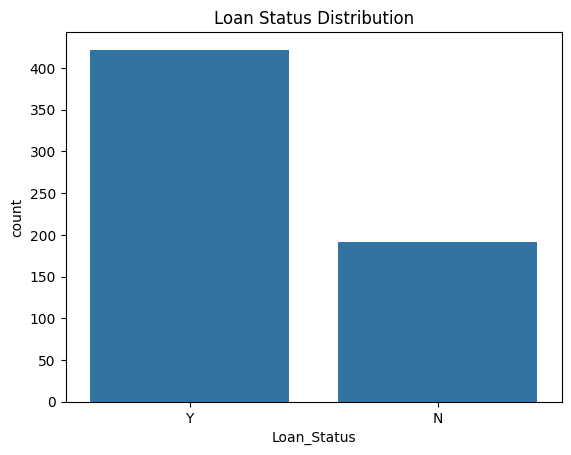

 Class distribution is reasonably balanced.


In [19]:
# 3. Exploratory Data Analysis (EDA)
# ===============================
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Target Variable Distribution ---")
class_counts = df['Loan_Status'].value_counts(normalize=True)
print(class_counts)

sns.countplot(data=df, x='Loan_Status')
plt.title("Loan Status Distribution")
plt.show()

# Check for significant class imbalance (e.g., more than 80% in one class)
if class_counts.max() > 0.8:
    print(" Warning: Significant class imbalance detected. Consider using class weighting or resampling techniques.")
else:
    print(" Class distribution is reasonably balanced.")


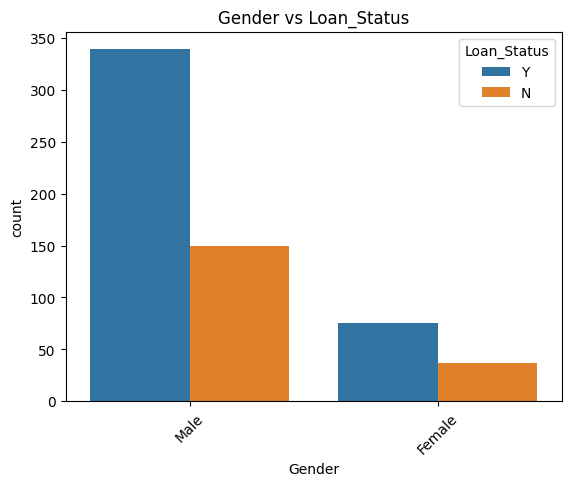

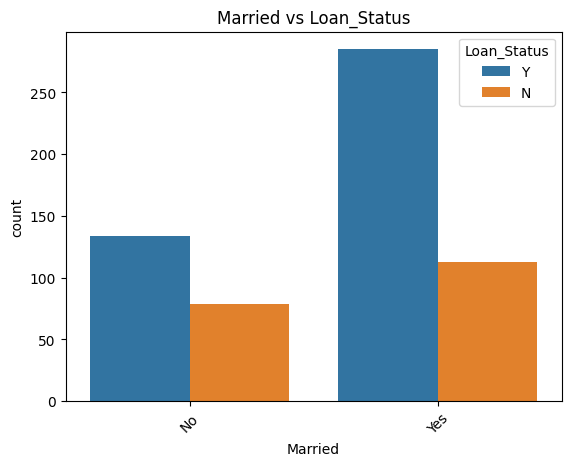

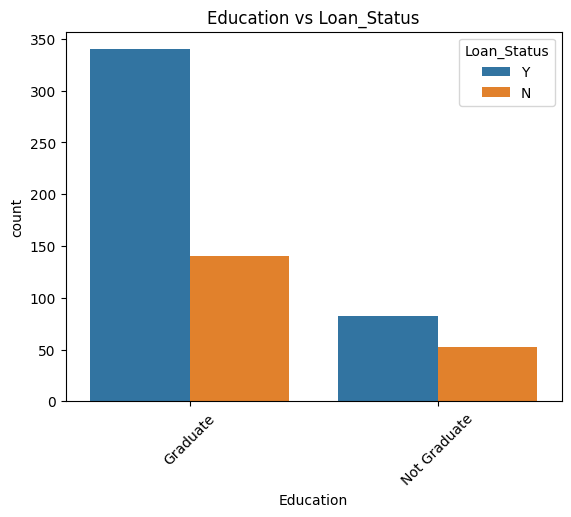

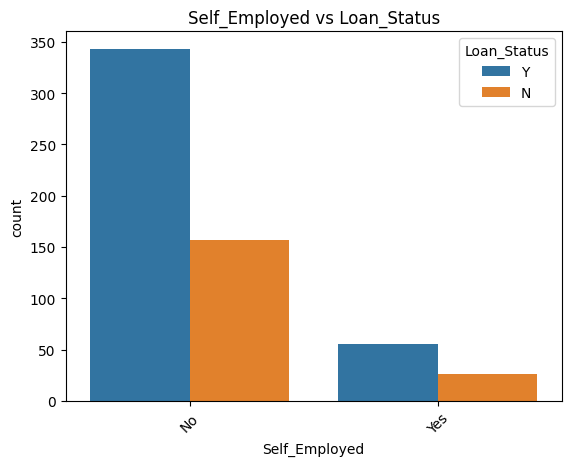

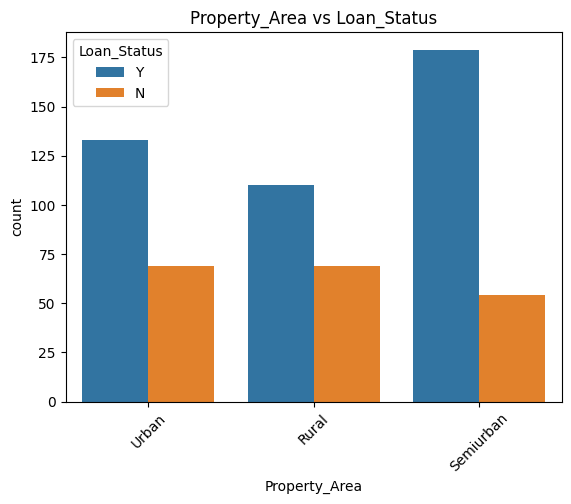

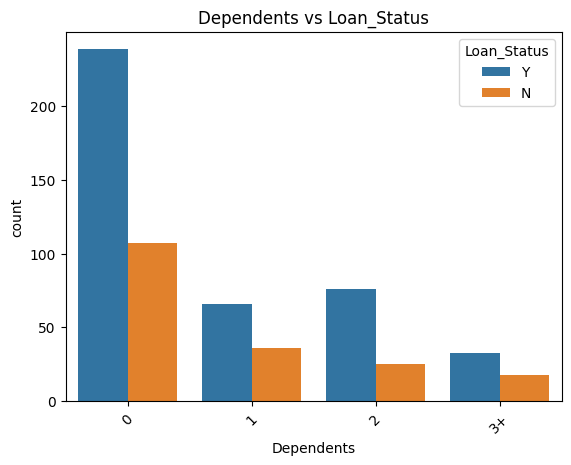

In [20]:
# Visualizing categorical features
def plot_categorical(feature):
    sns.countplot(data=df, x=feature, hue='Loan_Status')
    plt.title(f"{feature} vs Loan_Status")
    plt.xticks(rotation=45)
    plt.show()
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']
for feature in categorical_features:
    plot_categorical(feature)


In [21]:
df_original = df.copy()  # Backup before scaling

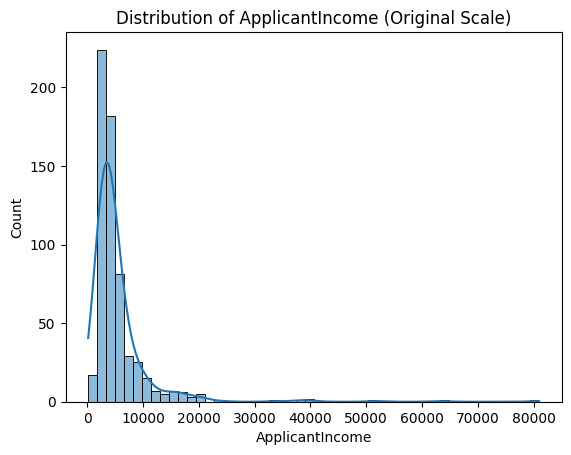

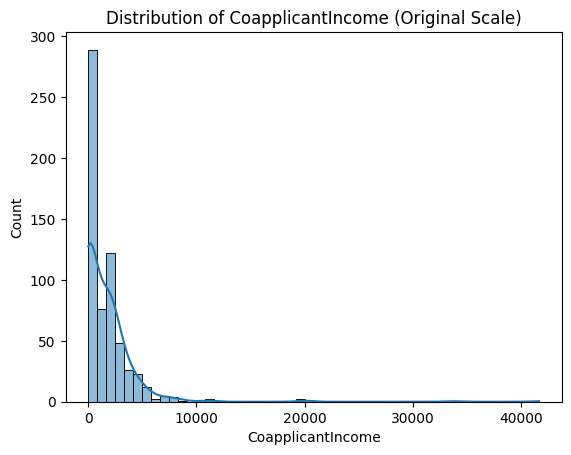

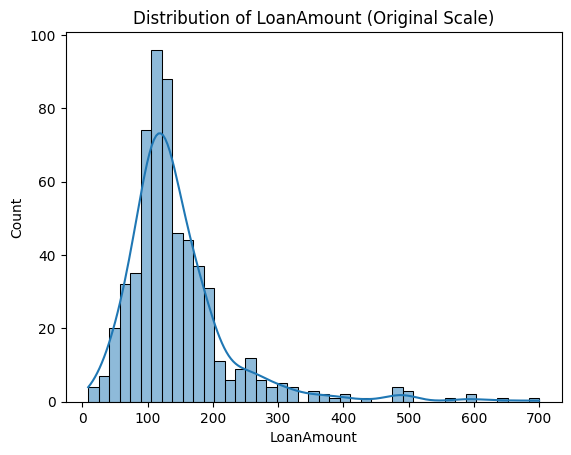

In [22]:
# Visualizing numerical distributions (before scaling)
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for feature in numeric_features:
    sns.histplot(df_original[feature].dropna(), kde=True)
    plt.title(f"Distribution of {feature} (Original Scale)")
    plt.xlabel(feature)
    plt.show()


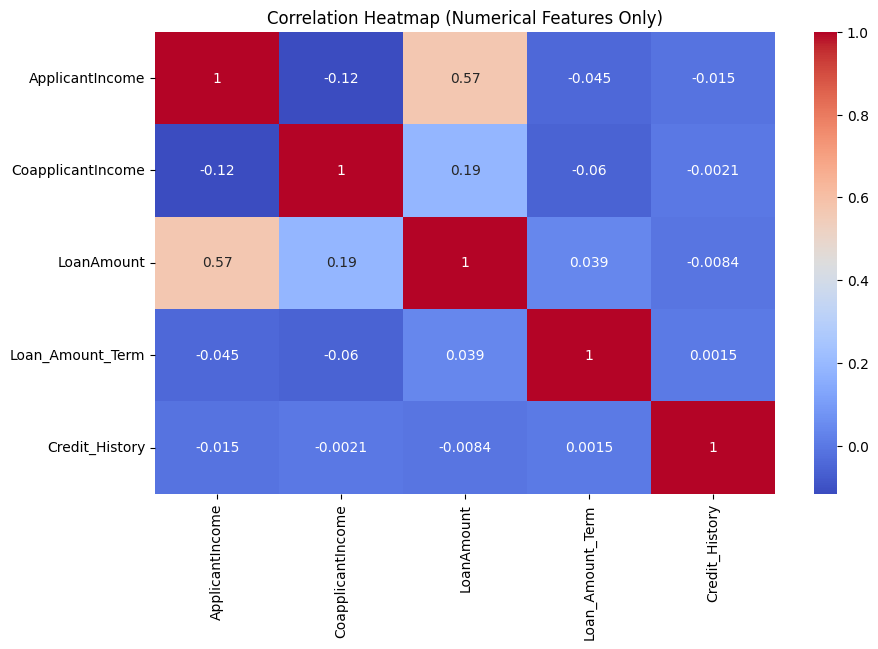

In [23]:
# Correlation heatmap
plt.figure(figsize=(10,6))

# Add numeric_only=True to ignore non-numerical columns
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap (Numerical Features Only)")
plt.show()

In [24]:
# 4. Data Preprocessing
# ===============================
# Fill missing values
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean 'Dependents': convert "3+" to 3
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# Encode categorical variables
label_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])




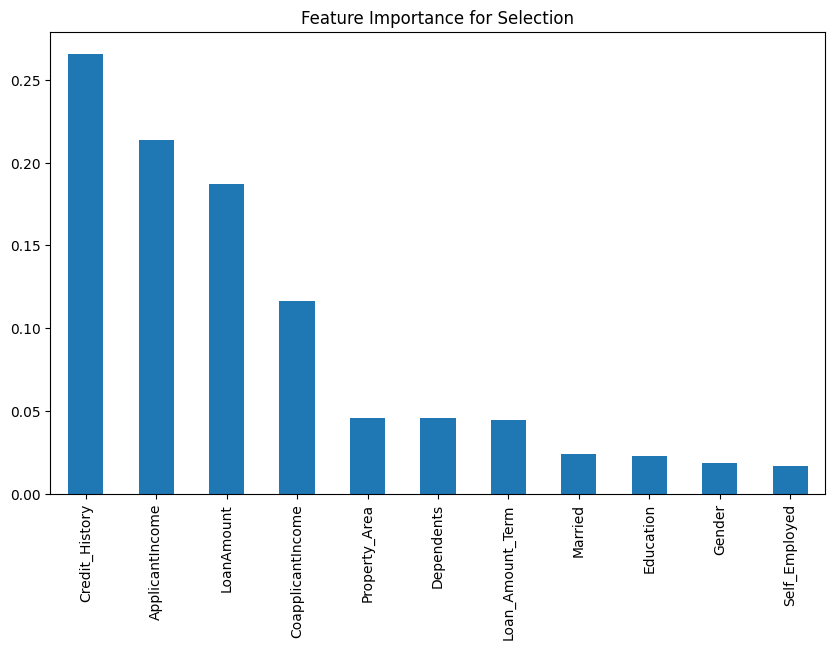


Selected features: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Property_Area']


In [25]:
# 5. Feature Selection (Using Random Forest Importance)
# ===============================
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

# Use RandomForest for feature importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X, y)

# Visualize feature importance
feat_importances = pd.Series(rf_selector.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance for Selection")
plt.show()

# Select top features using SelectFromModel
selector = SelectFromModel(rf_selector, prefit=True, threshold='median')
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]
print("\nSelected features:", list(selected_features))

In [26]:
# ===============================
# 6. Train-Test Split
# ===============================
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [27]:
# 7. Model Training
# ===============================
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
# 8. Model Evaluation
# ===============================
def evaluate_model(name, model, X_test, y_test):
    print(f"\nModel: {name}")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

lr_results = evaluate_model("Logistic Regression", lr, X_test, y_test)
dt_results = evaluate_model("Decision Tree", dt, X_test, y_test)




Model: Logistic Regression
Accuracy: 0.7886178861788617
Precision: 0.7596153846153846
Recall: 0.9875
F1 Score: 0.8586956521739131
Confusion Matrix:
 [[18 25]
 [ 1 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


Model: Decision Tree
Accuracy: 0.6991869918699187
Precision: 0.7654320987654321
Recall: 0.775
F1 Score: 0.7701863354037267
Confusion Matrix:
 [[24 19]
 [18 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.56        43
           1       0.77      0.78      0.77        80

    accuracy                           0.70       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.7

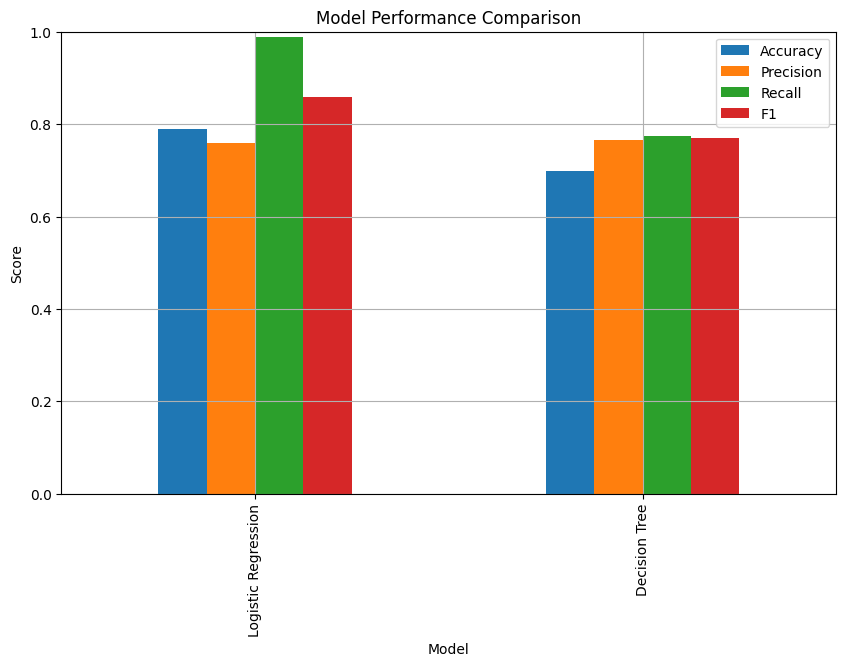

In [29]:
# Compare model performance
results_df = pd.DataFrame([lr_results, dt_results])
results_df.set_index('Model', inplace=True)
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

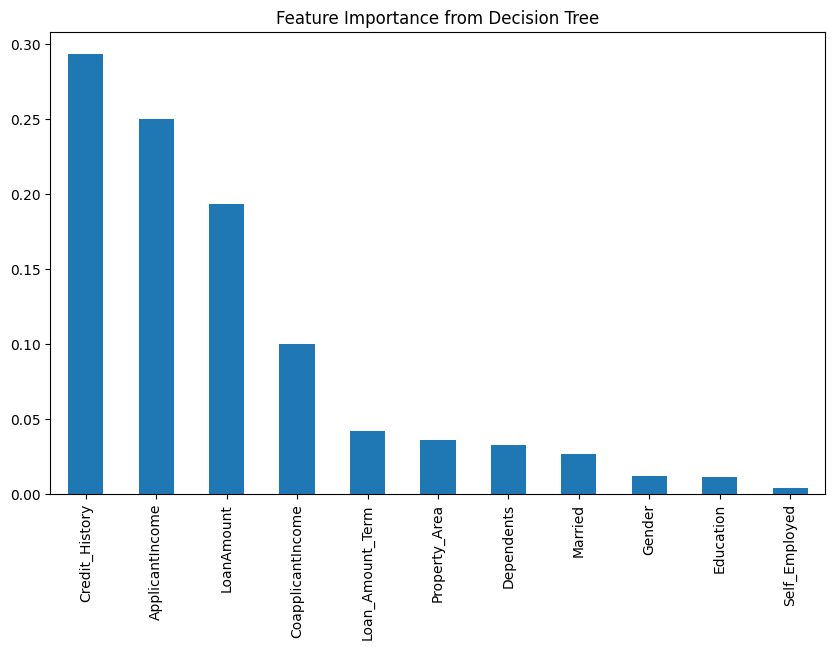

In [30]:
# Feature Importance from Decision Tree
importances = pd.Series(dt.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance from Decision Tree")
plt.show()
